# **Cài đặt và so sánh hiệu năng thuật toán ABC và biến thể của ABC**

*   Cấu hình hàm mục tiêu
*   Cài đặt khung sườn thuật toán ABC gốc (BaseABC)
*   Các biến thể cải tiến
*   Chạy thực nghiệm trên hàm mục tiêu đã định nghĩa


In [80]:
import numpy as np
import matplotlib.pyplot as plt

# --- HÀM 1: ĐA THỨC TỰ TẠO (Dễ) ---
def my_polynomial(x):
    # f(x) = sum(-3x^3 - 3x^2 + x + 1)
    # Global min in [-5, 5] is -444 * dim (at x=5)
    return np.sum(-3*x**3 - 3*x**2 + x + 1)

def get_polynomial_min(dim):
    # Global minimum of the 1D function -3x^3 - 3x^2 + x + 1 within [-5, 5] is -444 (at x=5)
    return -444 * dim

# --- HÀM 2: SPHERE ---
def sphere(x):
    return np.sum(x**2)

def get_sphere_min(dim):
    return 0.0

# --- HÀM MỤC TIÊU: SHIFTED RASTRIGIN (Rất Khó) ---
def shifted_rastrigin(x, shift=1.0):
    """
    Hàm Rastrigin: Có rất nhiều cực trị địa phương (nhiều "ổ gà").
    Global Min = 0 tại x = [shift, shift, ..., shift].
    Miền giá trị chuẩn: [-5.12, 5.12].
    """
    z = x - shift
    # Công thức Rastrigin chuẩn
    return np.sum(z**2 - 10*np.cos(2*np.pi*z) + 10)

def get_rastrigin_min(dim):
    return 0.0


# ============================================
# CẤU HÌNH BÀI TOÁN
# ============================================
# Chọn hàm muốn chạy:
CURRENT_FUNC = shifted_rastrigin       # Đổi thành my_polynomial nếu muốn
TARGET_FUNC = get_rastrigin_min      # Đổi tương ứng
DIMENSION = 20        # Đổi thành 5 với 2 func đầu, 20 với shifted_rastrigin
BOUNDS = [-5, 5]    #Bound của hàm sphere rộng [-100, 100]
TARGET = TARGET_FUNC(DIMENSION)

print(f"Bài toán đang chạy: {CURRENT_FUNC.__name__}")
print(f"Target mục tiêu: {TARGET:.4f}")

Bài toán đang chạy: shifted_rastrigin
Target mục tiêu: 0.0000


### Biểu đồ hàm mục tiêu (phiên bản 1D)
Biểu đồ dưới đây thể hiện hình dạng của hàm mục tiêu trong không gian 1 chiều (D=1), giúp trực quan hóa đặc điểm của hàm. Do các hàm đang xét là đa chiều, việc vẽ toàn bộ hàm trên không gian đa chiều là không khả thi trên đồ thị 2D.

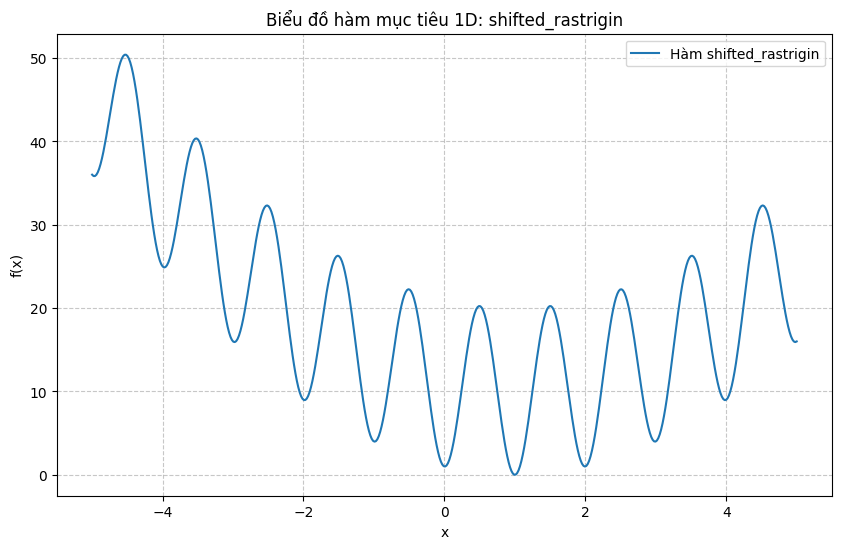

In [81]:
plt.figure(figsize=(10, 6))
x_vals = np.linspace(BOUNDS[0], BOUNDS[1], 500) # Lấy 500 điểm trong khoảng bounds
y_vals = [CURRENT_FUNC(np.array([x])) for x in x_vals] # Tính giá trị hàm cho từng điểm x (1D)

plt.plot(x_vals, y_vals, label=f'Hàm {CURRENT_FUNC.__name__}')
plt.title(f'Biểu đồ hàm mục tiêu 1D: {CURRENT_FUNC.__name__}')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Thêm dấu chấm cho nghiệm tối ưu nếu có (chỉ hiển thị nếu TARGET được xác định)
if TARGET is not None and CURRENT_FUNC.__name__ == 'my_polynomial':
    # For my_polynomial(x) = sum(-3x^3 - 3x^2 + x + 1), global min is at x=5
    if 'my_polynomial' in CURRENT_FUNC.__name__:
        plt.scatter([BOUNDS[1]], [TARGET / DIMENSION], color='red', marker='*', s=200, label='Nghiệm tối ưu lý thuyết (1D)')

plt.show()

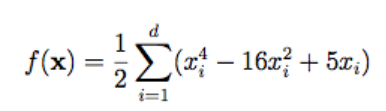

## Thuật toán Ong nhân tạo cơ sở (Base ABC)
Xây dựng khung sườn thuật toán với 3 giai đoạn:
1. **Employed Bee:** Tìm kiếm quanh vị trí hiện tại.
2. **Onlooker Bee:** Chọn lọc và tìm kiếm dựa trên xác suất (Roulette Wheel).
3. **Scout Bee:** Cơ chế thoát khỏi cực trị địa phương (Reset ngẫu nhiên).

In [84]:
class BaseABC:
    def __init__(self, func, dim, bounds, n_bees=40, max_iter=1000, limit=20, optimal_val=None):
        """
        Khởi tạo các tham số cho thuật toán.
        :param func: Hàm mục tiêu (cost function).
        :param dim: Số chiều của bài toán (D).
        :param bounds: Giới hạn tìm kiếm [min, max].
        :param n_bees: Tổng số ong (Colony Size).
        :param max_iter: Số vòng lặp tối đa (MCN).
        :param limit: Số lần thử thất bại trước khi reset nguồn thức ăn.
        :param optimal_val: Giá trị đích để tính sai số (nếu có).
        """
        self.func = func
        self.dim = dim
        self.bounds = bounds
        self.n_bees = n_bees
        self.n_employed = n_bees // 2   # 50% Ong thợ
        self.n_onlookers = n_bees // 2  # 50% Ong chờ
        self.max_iter = max_iter
        self.limit = limit
        self.optimal_val = optimal_val  # Đích đến lý thuyết

        # Tạo ngẫu nhiên vị trí các nguồn thức ăn trong giới hạn bounds
        self.population = np.random.uniform(bounds[0], bounds[1], (self.n_employed, dim))

        # Tính độ thích nghi (fitness) cho quần thể ban đầu
        self.fitness = np.array([self.calculate_fitness(ind) for ind in self.population])

        # Mảng đếm số lần không cải thiện (trials) cho mỗi nguồn thức ăn
        self.trials = np.zeros(self.n_employed)

        # Tìm nghiệm tốt nhất trong quần thể khởi tạo
        best_idx = np.argmax(self.fitness) # Fitness càng cao càng tốt
        self.best_solution = self.population[best_idx].copy()
        self.best_score = self.func(self.best_solution) # Tính giá trị Cost thực tế

    def calculate_fitness(self, x):
        """
        Chuyển đổi giá trị hàm mục tiêu (Cost) -> Độ thích nghi (Fitness).
        [cite_start]Công thức chuẩn của ABC[cite: 1204]:
        - Nếu f >= 0: fit = 1 / (1 + f)
        - Nếu f < 0:  fit = 1 + abs(f)
        Mục đích: Đảm bảo fitness luôn dương và tỉ lệ nghịch với Cost.
        """
        f = self.func(x)
        if f >= 0:
            return 1 / (1 + f)
        else:
            return 1 + abs(f)

    def greedy_selection(self, i, new_solution):
        new_fitness = self.calculate_fitness(new_solution)

        if new_fitness > self.fitness[i]:
            # Nếu tốt hơn: Cập nhật vị trí và fitness, reset bộ đếm trials
            self.population[i] = new_solution
            self.fitness[i] = new_fitness
            self.trials[i] = 0
        else:
            # Nếu tệ hơn (hoặc bằng): Giữ nguyên, tăng bộ đếm trials
            self.trials[i] += 1

    def mutate(self, i):
        # Để trống để lớp con ghi đè
        pass

    def run(self):
        """
        Vòng lặp chính thực thi thuật toán ABC.
        """
        error_history = [] # Lưu lịch sử sai số để vẽ biểu đồ nếu cần
        best_fitness_history = [] # New: To track the best fitness found at each iteration
        best_score_history = [] # New: To track the best objective score found at each iteration

        # Append initial values
        best_fitness_history.append(self.calculate_fitness(self.best_solution))
        best_score_history.append(self.best_score)

        for iteration in range(self.max_iter):
            # -------------------------------------------------------
            # GIAI ĐOẠN ONG THỢ (Employed Bees Phase)
            # -------------------------------------------------------
            for i in range(self.n_employed):
                new_solution = self.mutate(i)     # Tìm kiếm lân cận
                self.greedy_selection(i, new_solution) # Đánh giá & Chọn lọc

            # -------------------------------------------------------
            # GIAI ĐOẠN ONG CHỜ (Onlooker Bees Phase)
            # -------------------------------------------------------
            # B2.1: Tính xác suất chọn lọc (Roulette Wheel)
            # Nguồn thức ăn tốt hơn có xác suất được chọn cao hơn
            if np.sum(self.fitness) == 0:
                probabilities = np.ones(self.n_employed) / self.n_employed
            else:
                probabilities = self.fitness / np.sum(self.fitness)

            # B2.2: Ong chờ tỏa đi khai thác dựa trên xác suất
            for m in range(self.n_onlookers):
                # Chọn nguồn thức ăn i dựa trên xác suất p
                i = np.random.choice(range(self.n_employed), p=probabilities)

                # Tìm kiếm lân cận và đánh giá (giống ong thợ)
                # Kiểm tra: Nếu class có hàm 'mutate_onlooker' (là qABC) thì dùng nó
                # Còn không thì dùng mutate thường (ABC, GABC)
                if hasattr(self, 'mutate_onlooker'):
                    new_solution = self.mutate_onlooker(i)
                else:
                    new_solution = self.mutate(i)

                self.greedy_selection(i, new_solution)

            # -------------------------------------------------------
            # GIAI ĐOẠN 3: ONG TRINH SÁT (Scout Bees Phase)
            # -------------------------------------------------------
            # Tìm những nguồn thức ăn đã bị khai thác cạn kiệt (trials > limit)
            scout_bees = np.where(self.trials > self.limit)[0]

            for i in scout_bees:
                # Tạo nguồn thức ăn mới hoàn toàn ngẫu nhiên (Global Exploration)
                self.population[i] = np.random.uniform(self.bounds[0], self.bounds[1], self.dim)
                self.fitness[i] = self.calculate_fitness(self.population[i])
                self.trials[i] = 0 # Reset bộ đếm về 0

            # -------------------------------------------------------
            # GHI NHỚ NGHIỆM TỐT NHẤT (Memorize Best Solution)
            # -------------------------------------------------------
            current_best_idx = np.argmax(self.fitness)
            current_best_score = self.func(self.population[current_best_idx])

            # Cập nhật kỷ lục toàn cục nếu tìm thấy nghiệm tốt hơn
            if current_best_score < self.best_score:
                self.best_score = current_best_score
                self.best_solution = self.population[current_best_idx].copy()

            # New: Append current best fitness and score after potential update
            best_fitness_history.append(self.calculate_fitness(self.best_solution))
            best_score_history.append(self.best_score)

            # -------------------------------------------------------
            # TÍNH SAI SỐ (CALCULATE ERROR)
            # -------------------------------------------------------
            if self.optimal_val is not None:
                current_error = abs(self.best_score - self.optimal_val)
                error_history.append(current_error)

        return self.best_solution, self.best_score, error_history, best_fitness_history, best_score_history

## Các biến thể cải tiến (Proposed Variants)
Chúng ta so sánh 3 phiên bản:
1. **Classic ABC:** Dùng công thức lai ghép cơ bản.
2. **GABC (Gbest-guided):** Bổ sung lực hút về phía nghiệm tốt nhất toàn cục.
3. **qABC (Neighborhood):** Sử dụng cơ chế tìm kiếm trong bán kính lân cận (Local Neighborhood).

In [76]:
# --- Phiên bản 1: ABC Gốc ---
class ClassicABC(BaseABC):
    def mutate(self, i):
        k = np.random.choice([idx for idx in range(self.n_employed) if idx != i])
        phi = np.random.uniform(-1, 1, self.dim)
        new_solution = self.population[i] + phi * (self.population[i] - self.population[k])
        return np.clip(new_solution, self.bounds[0], self.bounds[1])

# --- Phiên bản 2: GABC ---
class GABC(BaseABC):
    def __init__(self, C=1.5, **kwargs):
        super().__init__(**kwargs)
        self.C = C

    def mutate(self, i):
        k = np.random.choice([idx for idx in range(self.n_employed) if idx != i])
        phi = np.random.uniform(-1, 1, self.dim)
        psi = np.random.uniform(0, self.C, self.dim)

        base_term = self.population[i] + phi * (self.population[i] - self.population[k])
        gbest_term = psi * (self.best_solution - self.population[i])

        new_solution = base_term + gbest_term
        return np.clip(new_solution, self.bounds[0], self.bounds[1])

# --- Phiên bản 3: qABC ---
class qABC(BaseABC):
    def __init__(self, radius_ratio=0.5, **kwargs):
        super().__init__(**kwargs)
        self.r = radius_ratio

    def mutate(self, i):
        # Employed phase giống ABC thường
        k = np.random.choice([idx for idx in range(self.n_employed) if idx != i])
        phi = np.random.uniform(-1, 1, self.dim)
        new_solution = self.population[i] + phi * (self.population[i] - self.population[k])
        return np.clip(new_solution, self.bounds[0], self.bounds[1])

    def mutate_onlooker(self, i):
        max_dist_space = np.linalg.norm(np.array([self.bounds[1]]*self.dim) - np.array([self.bounds[0]]*self.dim))
        radius = self.r * max_dist_space

        distances = np.linalg.norm(self.population - self.population[i], axis=1)
        neighbor_indices = np.where(distances <= radius)[0]

        if len(neighbor_indices) <= 1:
            neighbor_indices = np.arange(self.n_employed)

        neighbor_fitness = self.fitness[neighbor_indices]
        best_neighbor_idx = neighbor_indices[np.argmax(neighbor_fitness)]
        x_best_neighbor = self.population[best_neighbor_idx]

        possible_k = [idx for idx in range(self.n_employed) if idx != best_neighbor_idx]
        k = np.random.choice(possible_k)
        phi = np.random.uniform(-1, 1, self.dim)

        new_solution = x_best_neighbor + phi * (x_best_neighbor - self.population[k])
        return np.clip(new_solution, self.bounds[0], self.bounds[1])

## Chạy thực nghiệm và Đánh giá
Tiến hành chạy độc lập 3 thuật toán trên cùng một cấu hình để so sánh tốc độ hội tụ.

--> Đang chạy ABC Gốc...
--> Đang chạy GABC...
--> Đang chạy qABC...


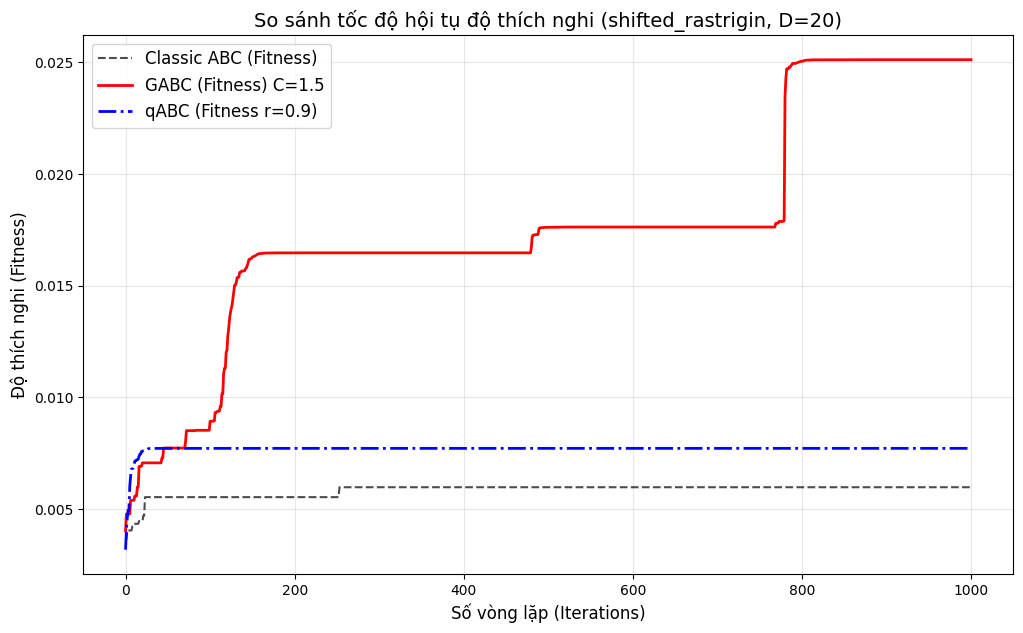

Algorithm       | Final Best Score     | Final Best Fitness  
------------------------------------------------------------
Classic ABC     | 1.662053e+02     | 5.980671e-03
GABC            | 3.880332e+01     | 2.512353e-02
qABC            | 1.285107e+02     | 7.721372e-03


In [85]:
# ========================================================
# CHẠY THỰC NGHIỆM VÀ VẼ BIỂU ĐỒ
# ========================================================
# np.random.seed(42)
# 1. Cấu hình tham số chung
PARAMS = {
    'func': CURRENT_FUNC,
    'dim': DIMENSION,
    'bounds': BOUNDS,
    'n_bees': 50,     # Số lượng ong
    'max_iter': 1000,  # 1000 vòng lặp cho SHIFTED RASTRIGIN;100 vòng lặp cho hàm đơn giản hơn như sphere
    'limit': 10,      # Giới hạn thử nghiệm
    'optimal_val': TARGET
}

# 2. Chạy lần lượt 3 thuật toán
# LƯU Ý: Hàm run() trả về 5 giá trị: (best_pos, best_val, error_history, best_fitness_history, best_score_history)
print("--> Đang chạy ABC Gốc...")
abc = ClassicABC(**PARAMS)
_, final_score_abc, _, hist_fitness_abc, hist_obj_abc = abc.run()

print("--> Đang chạy GABC...")
gabc = GABC(C=1.5, **PARAMS)
_, final_score_gabc, _, hist_fitness_gabc, hist_obj_gabc = gabc.run()

print("--> Đang chạy qABC...")
radius_ratio1 = 0.9
q_abc = qABC(radius_ratio=radius_ratio1, **PARAMS)
_, final_score_qabc, _, hist_fitness_qabc, hist_obj_qabc = q_abc.run()

# 3. Vẽ đồ thị so sánh
plt.figure(figsize=(12, 7))

plt.plot(hist_fitness_abc, 'k--', label='Classic ABC (Fitness)', alpha=0.7)
plt.plot(hist_fitness_gabc, 'r-', linewidth=2, label='GABC (Fitness) C=1.5')
plt.plot(hist_fitness_qabc, 'b-.', linewidth=2, label=f"qABC (Fitness r={radius_ratio1})")

# Trang trí đồ thị
plt.title(f'So sánh tốc độ hội tụ độ thích nghi ({CURRENT_FUNC.__name__}, D={DIMENSION})', fontsize=14)
plt.xlabel('Số vòng lặp (Iterations)', fontsize=12)
plt.ylabel('Độ thích nghi (Fitness)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, which="both", ls="-", alpha=0.3)

plt.show()

# 4. In kết quả cuối cùng ra màn hình
print(f"{'Algorithm':<15} | {'Final Best Score':<20} | {'Final Best Fitness':<20}")
print("-" * 60)
print(f"{'Classic ABC':<15} | {final_score_abc:.6e}     | {hist_fitness_abc[-1]:.6e}")
print(f"{'GABC':<15} | {final_score_gabc:.6e}     | {hist_fitness_gabc[-1]:.6e}")
print(f"{'qABC':<15} | {final_score_qabc:.6e}     | {hist_fitness_qabc[-1]:.6e}")

Đang chạy 30 lần để lấy kết quả trung bình...


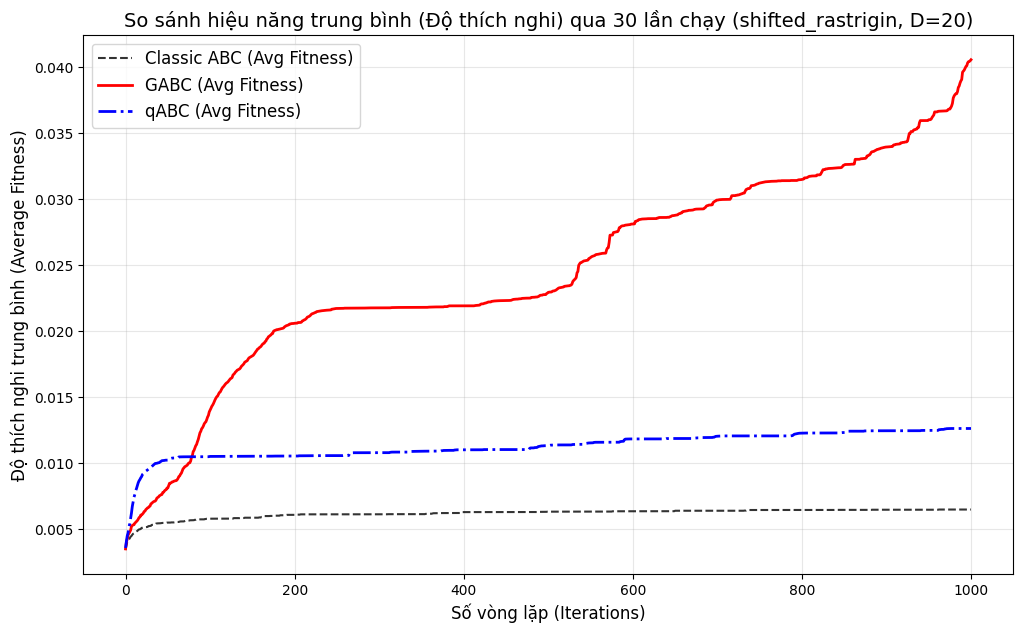

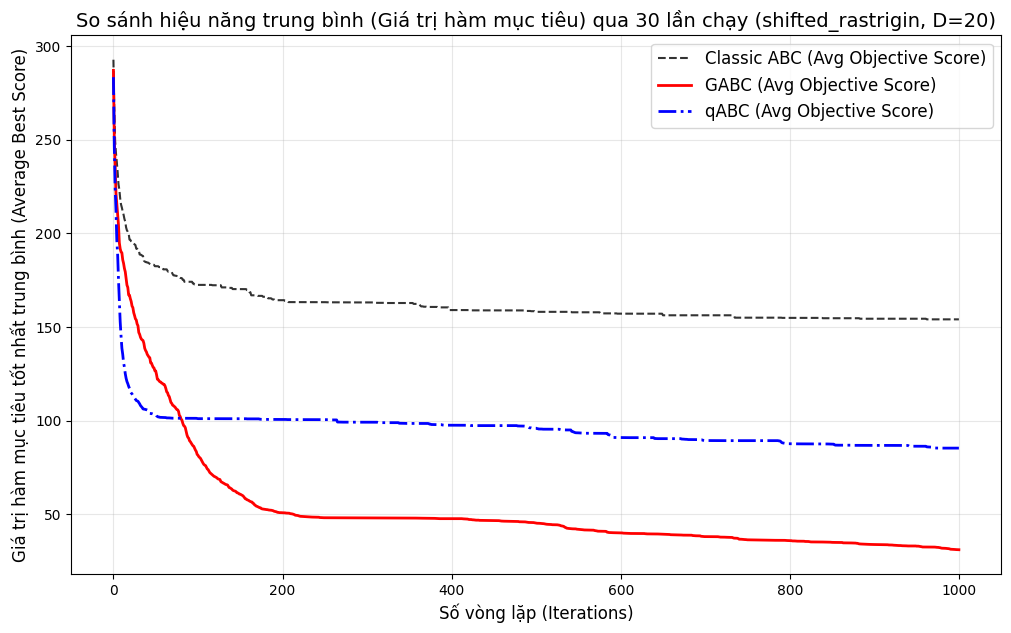


Algorithm       | Average Final Best Score  | Average Final Best Fitness
----------------------------------------------------------------------
Classic ABC     | 1.540455e+02 1.02e+01 | 6.479446e-03 4.54e-04
GABC            | 3.103251e+01 1.43e+01 | 4.057083e-02 2.49e-02
qABC            | 8.528768e+01 2.28e+01 | 1.262184e-02 4.24e-03


In [86]:
# ========================================================
# CHẠY THỰC NGHIỆM LẶP LẠI (ROBUST PLOTTING)
# ========================================================
N_RUNS = 30  # Chạy 30 lần để lấy trung bình
max_iter = PARAMS['max_iter'] # max_iter = 1000 cho hàm  SHIFTED RASTRIGIN; 100 vòng lặp cho hàm đơn giản hơn như sphere

# Mảng chứa lịch sử lỗi
hist_abc_total_fitness = np.zeros(max_iter + 1) # +1 for initial state
hist_gabc_total_fitness = np.zeros(max_iter + 1)
hist_qabc_total_fitness = np.zeros(max_iter + 1)

hist_abc_total_obj_score = np.zeros(max_iter + 1)
hist_gabc_total_obj_score = np.zeros(max_iter + 1)
hist_qabc_total_obj_score = np.zeros(max_iter + 1)

final_best_scores_abc = []
final_best_fitness_abc = []
final_best_scores_gabc = []
final_best_fitness_gabc = []
final_best_scores_qabc = []
final_best_fitness_qabc = []

print(f"Đang chạy {N_RUNS} lần để lấy kết quả trung bình...")

for r in range(N_RUNS):
    # 1. ABC
    abc = ClassicABC(**PARAMS)
    _, final_score, _, h_fitness, h_obj = abc.run()
    hist_abc_total_fitness += np.array(h_fitness)
    hist_abc_total_obj_score += np.array(h_obj)
    final_best_scores_abc.append(final_score)
    final_best_fitness_abc.append(h_fitness[-1])

    # 2. GABC
    gabc = GABC(C=1.5, **PARAMS)
    _, final_score, _, h_fitness, h_obj = gabc.run()
    hist_gabc_total_fitness += np.array(h_fitness)
    hist_gabc_total_obj_score += np.array(h_obj)
    final_best_scores_gabc.append(final_score)
    final_best_fitness_gabc.append(h_fitness[-1])

    # 3. qABC
    q_abc = qABC(radius_ratio=1.0, **PARAMS)
    _, final_score, _, h_fitness, h_obj = q_abc.run()
    hist_qabc_total_fitness += np.array(h_fitness)
    hist_qabc_total_obj_score += np.array(h_obj)
    final_best_scores_qabc.append(final_score)
    final_best_fitness_qabc.append(h_fitness[-1])

# Chia trung bình
avg_abc_fitness = hist_abc_total_fitness / N_RUNS
avg_gabc_fitness = hist_gabc_total_fitness / N_RUNS
avg_qabc_fitness = hist_qabc_total_fitness / N_RUNS

avg_abc_obj_score = hist_abc_total_obj_score / N_RUNS
avg_gabc_obj_score = hist_gabc_total_obj_score / N_RUNS
avg_qabc_obj_score = hist_qabc_total_obj_score / N_RUNS

# Vẽ đồ thị trung bình độ thích nghi
plt.figure(figsize=(12, 7))
plt.plot(avg_abc_fitness, 'k--', label='Classic ABC (Avg Fitness)', alpha=0.8)
plt.plot(avg_gabc_fitness, 'r-', label='GABC (Avg Fitness)', linewidth=2)
plt.plot(avg_qabc_fitness, 'b-.', label='qABC (Avg Fitness)', linewidth=2)

plt.title(f'So sánh hiệu năng trung bình (Độ thích nghi) qua {N_RUNS} lần chạy ({CURRENT_FUNC.__name__}, D={DIMENSION})', fontsize=14)
plt.xlabel('Số vòng lặp (Iterations)', fontsize=12)
plt.ylabel('Độ thích nghi trung bình (Average Fitness)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# Vẽ đồ thị trung bình giá trị hàm mục tiêu
plt.figure(figsize=(12, 7))
plt.plot(avg_abc_obj_score, 'k--', label='Classic ABC (Avg Objective Score)', alpha=0.8)
plt.plot(avg_gabc_obj_score, 'r-', label='GABC (Avg Objective Score)', linewidth=2)
plt.plot(avg_qabc_obj_score, 'b-.', label='qABC (Avg Objective Score)', linewidth=2)

plt.title(f'So sánh hiệu năng trung bình (Giá trị hàm mục tiêu) qua {N_RUNS} lần chạy ({CURRENT_FUNC.__name__}, D={DIMENSION})', fontsize=14)
plt.xlabel('Số vòng lặp (Iterations)', fontsize=12)
plt.ylabel('Giá trị hàm mục tiêu tốt nhất trung bình (Average Best Score)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# 4. In kết quả cuối cùng ra màn hình
print(f"\n{'Algorithm':<15} | {'Average Final Best Score':<25} | {'Average Final Best Fitness':<25}")
print("-" * 70)
print(f"{'Classic ABC':<15} | {np.mean(final_best_scores_abc):.6e} {np.std(final_best_scores_abc):.2e} | {np.mean(final_best_fitness_abc):.6e} {np.std(final_best_fitness_abc):.2e}")
print(f"{'GABC':<15} | {np.mean(final_best_scores_gabc):.6e} {np.std(final_best_scores_gabc):.2e} | {np.mean(final_best_fitness_gabc):.6e} {np.std(final_best_fitness_gabc):.2e}")
print(f"{'qABC':<15} | {np.mean(final_best_scores_qabc):.6e} {np.std(final_best_scores_qabc):.2e} | {np.mean(final_best_fitness_qabc):.6e} {np.std(final_best_fitness_qabc):.2e}")

### Kết quả chạy cho hàm Shifted_rastrigin

---
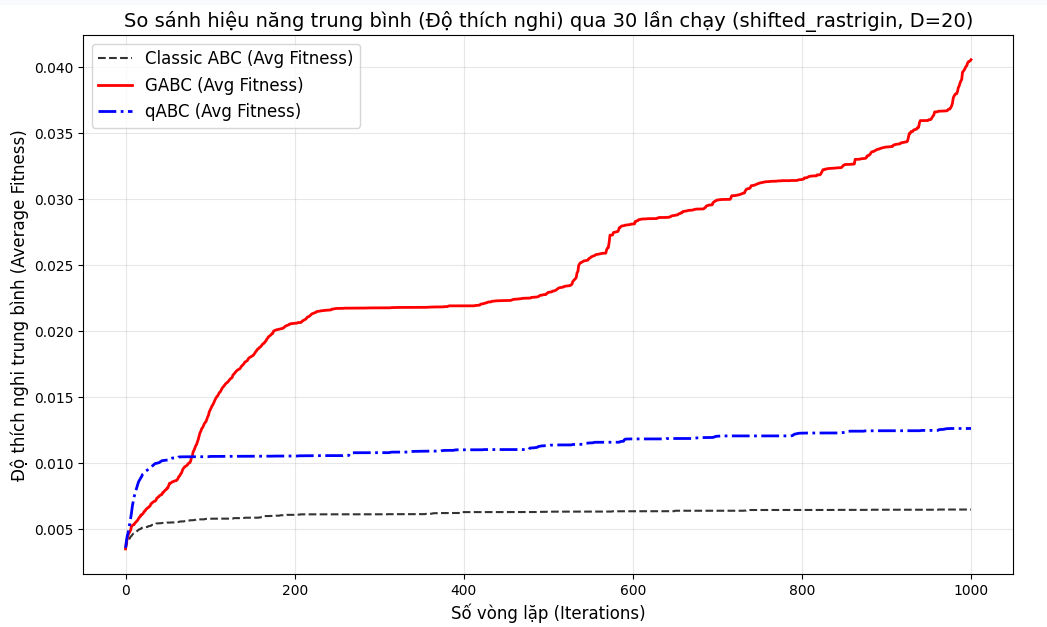
---
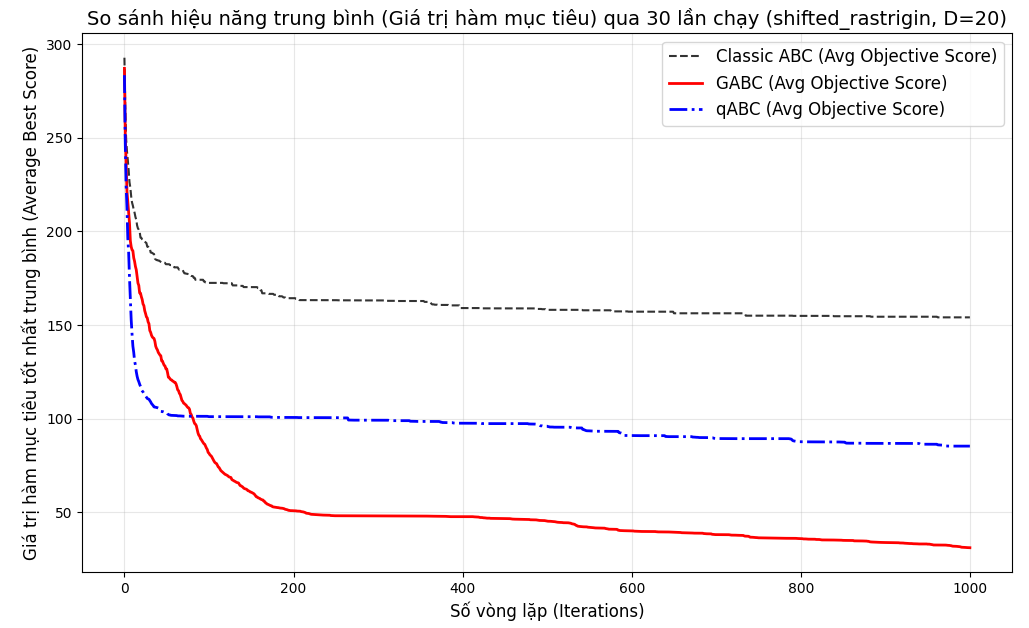
---
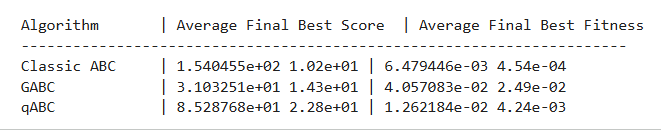


# Kết quả chạy thử nghiệm hàm đơn giản
Với function đơn giản

## Hàm Sphere
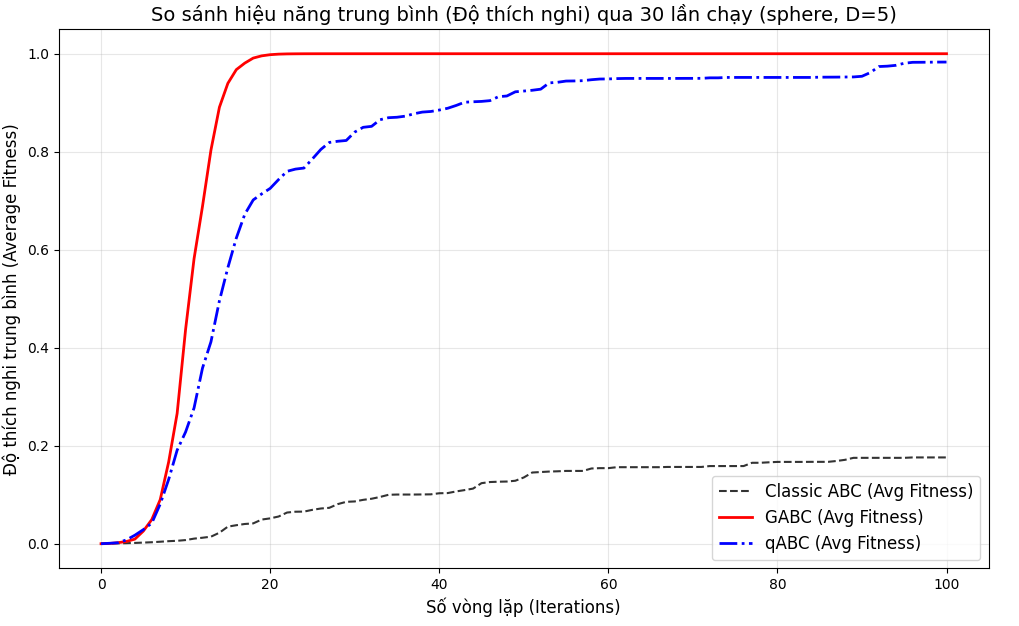

---
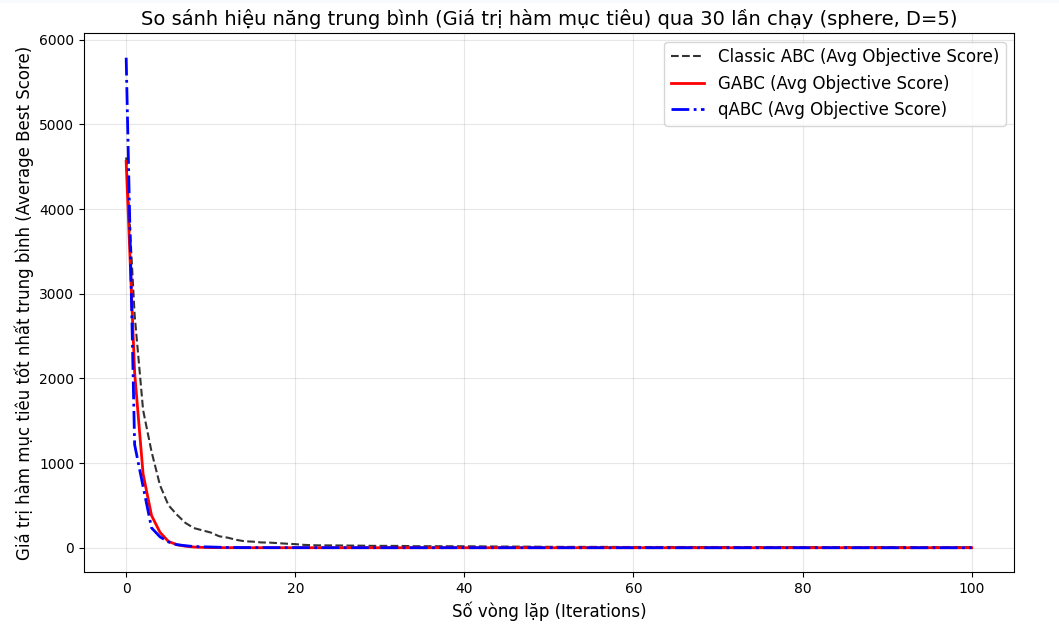
---
 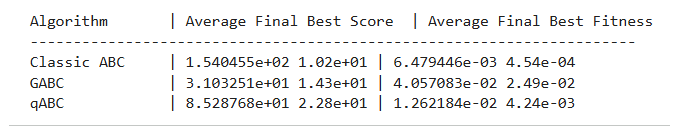

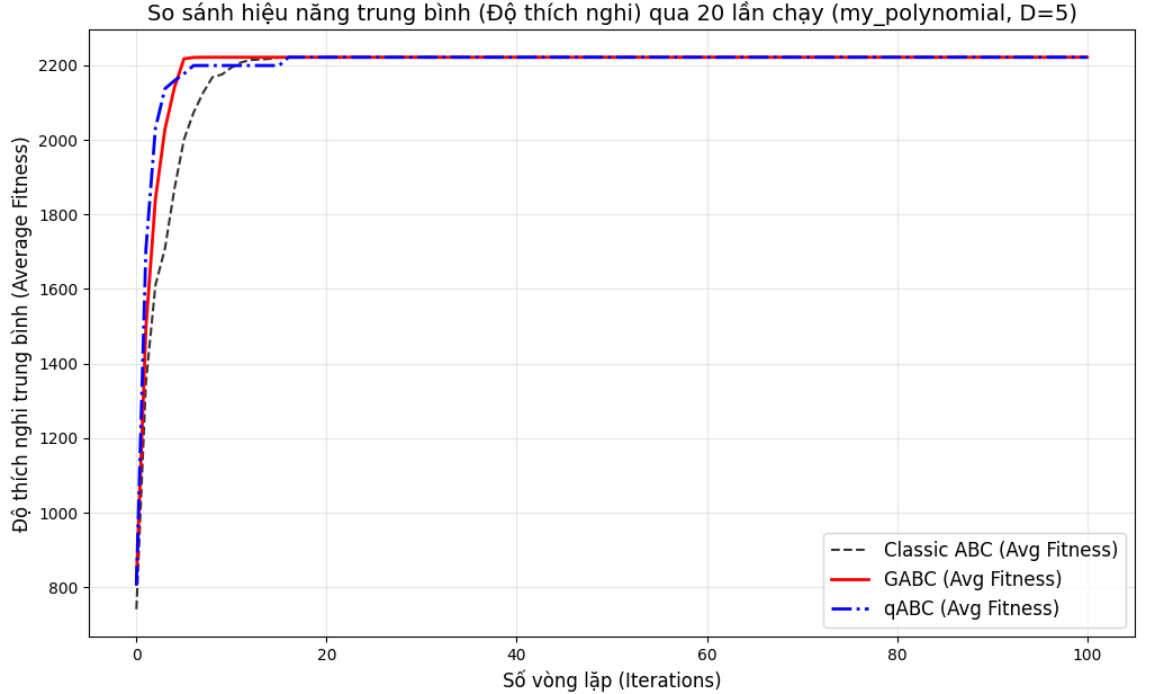


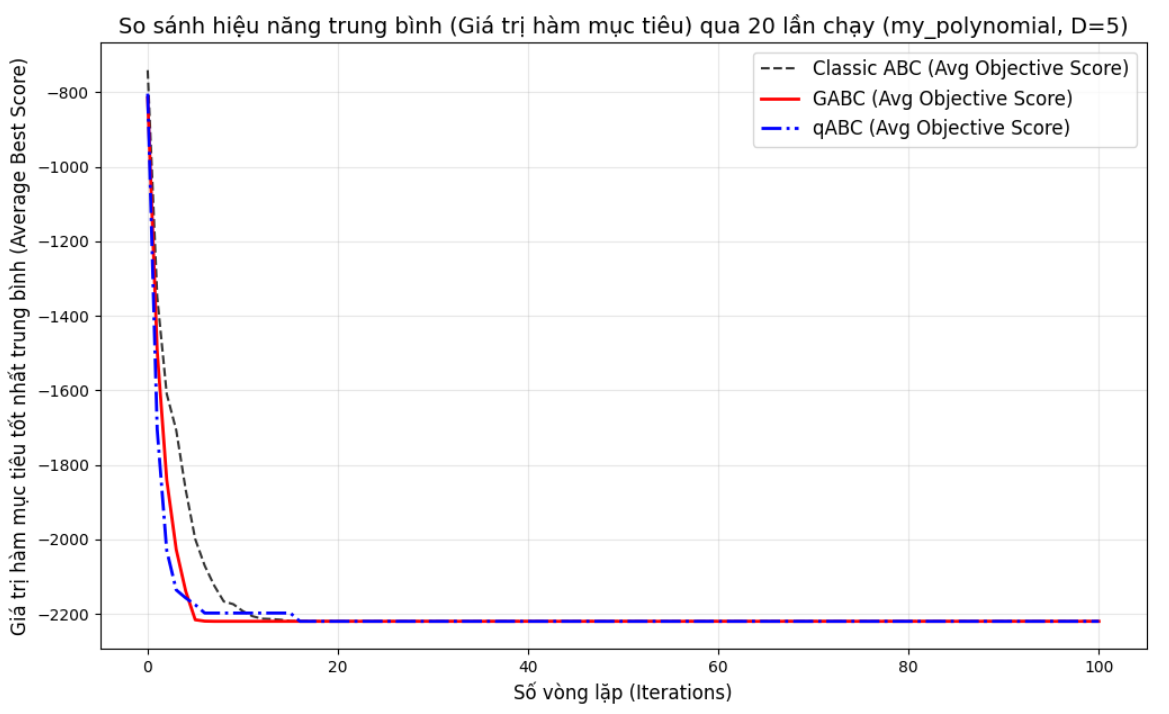
---

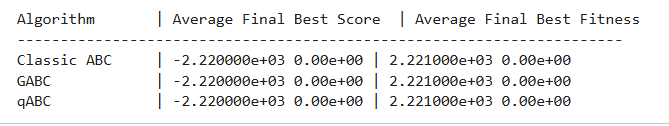
